# 机器学习练习2-逻辑回归


使用python语言完成作业

代码修改并注释：Changersh，Changersh@outlook.com

# 1、逻辑回归
假设您是大学某系的管理员，您希望根据每个申请人的两次考试成绩来确定他们的录取机会。
您拥有以前申请人的历史数据，可以将其用作逻辑回归的训练集。
对于每个培训示例，您都有申请人在两次考试中的分数和录取决定。
您的任务是构建一个分类模型，根据这两次考试的分数估计申请人的录取概率。

In [384]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1.1 原始数据可视化

In [385]:
path = 'ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam-1', 'Exam-2', 'Admitted'])
data.head()

,Exam-1,Exam-2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


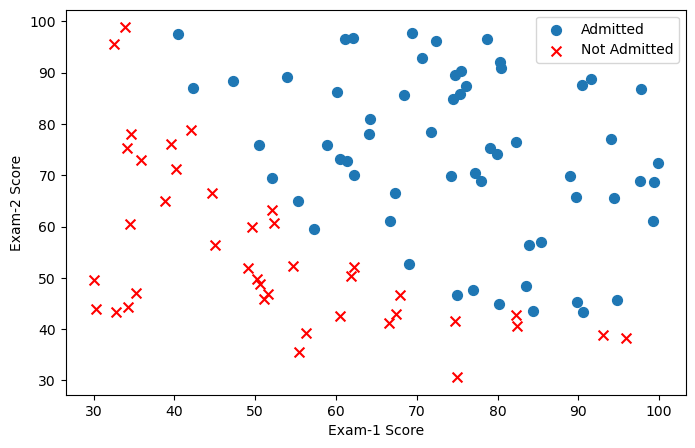

In [386]:
# .isin 筛选 使用 isin() 函数判断 data['Admitted'] 列中的每个元素是否在列表 [1] 中，返回一个布尔类型的 Series 对象。
positive = data[data['Admitted'].isin([1])]
negative = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(positive['Exam-1'], positive['Exam-2'], s=50, marker='o', label='Admitted') # label：图例
ax.scatter(negative['Exam-1'], negative['Exam-2'], s=50, marker='x', color='r', label='Not Admitted')

ax.legend() # 添加图例，如果没有这一句，前面即使写了 label 也不显示

ax.set_xlabel('Exam-1 Score')
ax.set_ylabel('Exam-2 Score')

plt.show()

上图看起来，在两类之间有明显的分界。下面我们训练模型来预测。

## 1.2 构建模型

### 1.2.1 sigmoid function
s型函数，即下面的g函数
我们的假设函数为：
$$
h_\theta(x)=g(\theta^TX) \\
其中：\\
g(z)=\frac{1}{1+e^{-z}}
$$

首先，我们构造这个函数

In [387]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

检查一下函数是否能正常工作

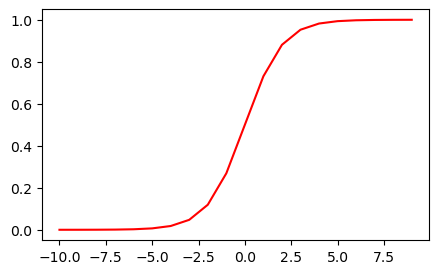

In [388]:
sigmoid(0) # 0.5
test = np.arange(-10, 10, step=1)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(test, sigmoid(test), 'r')
plt.show()

### 1.2.2 代价函数梯度下降
逻辑回归的代价函数：
$$
J(\theta)= - \frac{1}{m}\sum_{i=1}^m[y^{(i)}*log(h_\theta(x^{i})) + (1-y^{i})*log(1-h_\theta(x^{i}))]
\\
其中
h_\theta=g(\theta^TX)
$$

In [389]:
# 由于 first最后剩两项 都是 100x1 的，很麻烦，我也没有贸然转置，只能学大佬的方法转成 matrix 使用 multiply
# 这样就不用顾及其他了
def cost(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))

    return np.sum(-(first + second)) / X.shape[0]

重复在线性回归中做过的操作

In [390]:
# 最前面添加一列
data.insert(0, 'Ones', 1)

In [391]:
len = data.shape[1]
X = data.iloc[:, :len-1].values # .values 转化成 np.array类型的矩阵
y = data.iloc[:, len-1:len].values

theta = np.zeros(len-1)
theta

array([0., 0., 0.])

|检查矩阵维度

In [392]:
X.shape, theta.shape, y.shape

((100, 3), (3,), (100, 1))

计算初始化 theta 为 0 时的Cost函数

In [393]:
cost(theta, X, y) # 0.693

0.6931471805599453

效果不错

### 1.2.3 使用fminunc学习参数
使用更高级的算法来最小化函数
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

可以看出，上式中没有 α，因为这只是计算梯度的函数，之后的高级算法会自动给出学习率alpha

In [394]:
def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = X.shape[1] # 参数个数
    grad = np.zeros(parameters) # 存储梯度

    error = sigmoid(X * theta.T) - y

    # 遍历所有的 theta
    for i in range(parameters):
        term = np.multiply(error, X[:, i])
        grad[i] = np.sum(term) / X.shape[0] # 更新梯度

    return grad

In [395]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

作业中使用的是matlab中的函数，我们使用scipy库中的函数，效果是一样的。
> func=cost：这是要最小化的目标函数。在这里，cost 是一个函数，根据给定的参数 theta、输入数据 X 和目标值 y 计算并返回损失值。
> x0=theta：这是优化的起始点，也就是初始解。theta 是一个包含变量的初始向量或数组。
> fprime=gradient：这是计算目标函数在给定点处的梯度的函数。在这里，gradient 是一个函数，根据给定的参数 theta、输入数据 X 和目标值 y 计算并返回梯度向量。
> args=(X, y)：这是传递给目标函数和梯度函数的额外参数。在这里，我们将输入数据 X 和目标值 y 作为额外参数传递给目标函数 cost 和梯度函数 gradient。

`opt.fmin_tnc()`：结果的第一个元素是最优的θ，第二个元素是最小值

In [396]:
import scipy.optimize as opt
# fmin_tnc 拟牛顿法用于最小优化问题
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
result

(array([-25.16131863,   0.20623159,   0.20147149]), 36, 0)

拟合出来的theta放在result中，有两个维度，result[0]是theta，result[1] 是最小值
我们使用最新的参数，带入cost计算

In [397]:
cost(result[0], X, y) # 0.203

0.20349770158947458

### 1.2.4 评估逻辑回归
学习参数后，您可以使用模型来预测特定学生是否会被录取。对于一个考试1分数为45，考试2分数为85的学生，你应该期望看到0.776的录取概率。

In [398]:
theta_min = np.matrix(result[0])
X_test = np.array([1, 45, 85])
print(sigmoid(X_test * theta_min.T))

[[0.77629062]]


第二种评估方式是查看预测的正确率
我们写一个预测函数来预测录取率，录取率>= 0.5 就是 1，否则就是 0
预测函数$h_\theta = g(\theta^TX)$

In [399]:
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [400]:
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = sum(correct) / np.array(correct).shape[0] * 100 # len(correct) 一直报 int 错误，只能转成 ndarray了
print ('accuracy = {0}%'.format(accuracy))

accuracy = 89.0%


# 2、正则化逻辑回归方程
正则化，会得到更小的参数值，有助于防止过拟合的问题

您将实现正则化逻辑回归来预测来自制造厂的微芯片是否通过质量保证（QA）
假设你是工厂的产品经理，你有两个不同测试的一些微芯片的测试结果。从这两个测试中，您想确定是否应该接受或拒绝微芯片。

## 2.1 数据可视化

In [401]:
path = 'ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


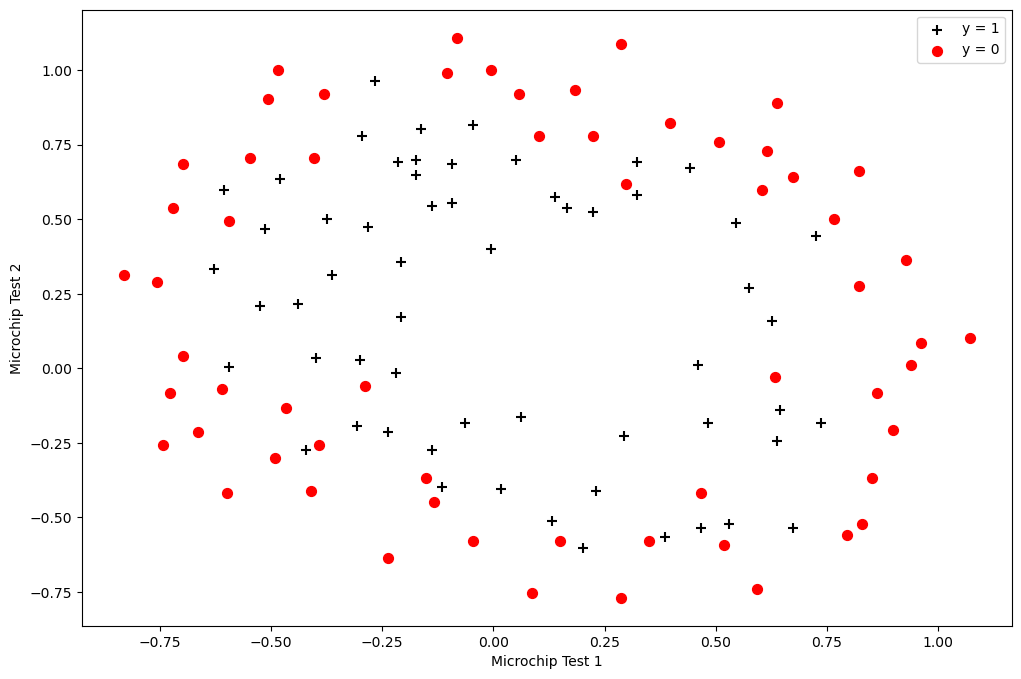

In [402]:
positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

fix, ax = plt.subplots(figsize=(12, 8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, color='black', marker='+', label='y = 1')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, color='red', marker='o', label='y = 0')

ax.set_xlabel('Microchip Test 1')
ax.set_ylabel('Microchip Test 2')

ax.legend()
plt.show()

这个图看着就很复杂，没有上一部分那种很明显的特征分界线

## 2.2 特征映射

一种比较好的拟合数据的方式是根据已有的数据，扩展出更多的特征值，我们将特征映射到x1和x2的所有多项式项中，直到六次方。
扩展方式如下：
$$
mapFeature(x) = [1, x_1, x_2, x_1^2, x_1 x_2, x_2^2......x_1x_2^5, x_2^6]
$$
我们按照上面的方式构造出一组特征向量吧，也许不用那么多项的

In [403]:
data2.insert(3, 'Ones', 1) # 末尾插入 1 表示theta0， 之后会把前面的列都删掉的

In [404]:
degree = 5
x1 = data2['Test 1']
x2 = data2['Test 2']

for i in range(1, degree):
    for j in range(0, i):
        data2['F' + str(i - j) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data2.drop('Test 1', axis=1, inplace=True)
data2.drop('Test 2', axis=1, inplace=True)
data2.head()

,Accepted,Ones,F10,F20,F11,F30,F21,F12,F40,F31,F22,F13
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


## 2.3 正则化逻辑回归
$$
J(\theta)= - \frac{1}{m}\sum_{i=1}^m[y^{(i)}*log(h_\theta(x^{i})) + (1-y^{i})*log(1-h_\theta(x^{i}))] + \frac{\lambda}{2m}\sum_{j=1}^n \theta_j^2
$$

In [405]:
def costReg(theta, X, y, lam):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    first = np.multiply(y, np.log(sigmoid(X * theta.T)))
    second = np.multiply(1 - y, np.log(1 - sigmoid(X * theta.T)))
    reg = (lam / (2 * X.shape[0])) * np.sum(np.power(theta, 2))

    return -(np.sum(first + second)) / X.shape[0] + reg

lam就是上面式子中的λ，是正则化参数，不能太大，否则会导致拟合效果很差。
我们也要写出更新参数 θ 的函数，并且不用给出 学习速率α，因为我们后面使用第一题使用过的高级的方法，会自动给出学习速率
$$
Repeat \ until \ convergence \{ \\
\theta_0 := \theta_0 - \alpha \frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)}) -y^{(i)})x_0^{(i)}
\\
\theta_j := \theta_j - \alpha [\frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)}) -y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\theta_j]
\\
\}
$$

后面一项可以化简
$$
\theta_j := \theta_j(1-\alpha \frac{\lambda}{m}) - \alpha \frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)}) -y^{(i)})x_j^{(i)}
$$

这里只计算减号后面的梯度即可，并且不用带α

In [1]:
def gradientReg(theta, X, y, lam):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = X.shape[1]
    grad = np.zeros(parameters) # 存储梯度

    error = sigmoid(X * theta.T) - y # 这一项跟theta没关系，预处理出来
    for i in range(parameters):
        tmp = np.sum(np.multiply(error, X[:, i])) / X.shape[0]
        if i == 0:
            grad[i] = tmp
        else:
            grad[i] = tmp + (lam * theta[:, i]) / X.shape[0]

    return grad

初始化变量

In [407]:
# 设置X2、y2 并且转换成 ndarray 类型
cols = data2.shape[1]
X2 = data2.iloc[:, 1:cols].values
y2 = data2.iloc[:, 0:1].values

# theta初始化全为0
theta2 = np.zeros(cols - 1)

# 设置正则化系数 lambda
lam = 1

测试一下，使用初始化的系数，调用函数，得到初始代价

In [408]:
costReg(theta2, X2, y2, lam) # 0.693

0.6931471805599454

### 2.3.1 使用fmin_tnc函数求解

In [409]:
# fmin_tnc 拟牛顿法用于最小优化问题
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X2, y2, lam))
result2

(array([ 0.53010249,  0.29075567, -1.60725763, -0.5821382 ,  0.01781027,
        -0.21329508, -0.40024142, -1.37144139,  0.02264303, -0.9503358 ,
         0.0344085 ]),
 22,
 0)

可以使用第一部分的预测函数来查看我们的准确度

In [410]:
theta_min = np.matrix(result2[0])
predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
accuracy = sum(correct) / np.array(correct).shape[0] * 100 # len(correct) 一直报 int 错误，只能转成 ndarray了
print ('accuracy = {0}%'.format(accuracy))

accuracy = 66.10169491525424%
